<a href="https://colab.research.google.com/github/JuanM-GG/modelos-tesis/blob/main/optimizacion_tasa_dilucion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Título: Optimización de la tasa de dilución $D$

Autor: Juan Manuel Gutiérrez García 

Fecha: enero 2021

# Resumen 
En el presente cuaderno llevamos a cabo la optimización de la tasa de dilución. El problema consiste en encontrar el valor de la tasa de dilución, $D$, que permita generar la mayor productividad de biomasa, $\dot{m}_x$, y etanol, ${m_p}$, en condiciones estacionarias. Para realizar esta optimización se consideran los parámetros cinéticos de las levaduras *Isstchenkia terrícola*, *Kluyveromyces marxianus*, *Pichia kluyveri*, *Zygosaccharomyces bailii* y *Zigosaccharomyces rouxi* obtenidos anteriormente mediante optimización paramétrica. 

# Modelo para la optimización

Ahora podríamos preguntarnos sobre cuál es el valor del parámetro $D$ que nos permite generar una mayor cantidad de biomasa. Consideremos, por ejemplo, una valor de $D$ muy bajo. Como vimos en el diagrama de bifurcación, un valor bajo da lugar a un valor de concentración de biomasa en el equilibrio, $\bar{x}$, alto, sin embargo, al ser el flujo en la salida del biorreactor demasiado bajo, el flujo de biomasa en la salida también lo será. Por otro lado, si el valor de $D$ es muy alto, tendremos un mayor flujo de biomasa en la salida pero de acuerdo con el diagrama de bifurcación, el valor de la concentración de biomasa será muy bajo y corremos el riesgo de llevar al sistema al punto de equilibrio trivial $ss_1$ donde no existe biomasa. 

Para resolver este problema de optimización empezamos por definir la función que nos interesa optimizar, en este caso, esta función es la cantidad de biomasa que se obtiene del biorreactor

$$G(D) = D \bar{x}$$

Donde $\bar{x}$ es la concetración de biomasa en el equilibrio. 

Considerando 

$$\bar{x} = Y_{xs} (s_f - \bar{s}) \hspace{1cm} y \hspace{1cm} \bar{s} = \frac{D k_s}{\mu_{max} - D}$$

Tenemos 

$$G(D) = D Y_{xs} (s_f - \frac{D k_s}{\mu_{max} - D})$$

In [90]:
# cargar librerías
library(ggplot2)

In [271]:
p <- c(mu_max = 1.2, ks = 180, Yxs = 0.1, Ypx = 2,sf = 80, D = 0.01)

In [272]:
#@title establecer función objetivo 
# aquí x representa la variable a optimizar, osea D 
productivity_func <- function(x, p) {
  with(as.list(p), {

    productivity_x = x*Yxs*(sf - x*ks/(mu_max - x))
    productivity_p = x*Yxs*Ypx*(sf - x*ks/(mu_max - x))
    return(list(productivity_x = productivity_x, productivity_p = productivity_p))

  })
}

In [273]:
# valores de D a evaluar
x <- seq(0,0.2,len=100)

In [274]:
# obtener productividad
productivity <- productivity_func(x,p)

In [275]:
#@title función para generar datos con productividad
get_data_productivity <- function(productivity) {
    # guardar resultados 
    out <- data.frame(D = rep(x,2), productivity = c(productivity$productivity_x, 
                                    productivity$productivity_p), 
                                    var = rep(factor(c("x","p")), each = length(x)))
    return(out)
}

In [276]:
out <- get_data_productivity(productivity)
head(out)

,D,productivity,var
,<dbl>,<dbl>,<fct>
1,0.000000000,0.00000000,x
2,0.002020202,0.01610029,x
3,0.004040404,0.03207753,x
4,0.006060606,0.04793109,x
5,0.008080808,0.06366033,x
6,0.010101010,0.07926463,x


In [277]:
#@title función para graficas la productividad
plot_productivity <- function(out) {
    ggplot(out, aes(x = D, y = productivity, color = var)) +
    geom_line(lty = 1, lwd = 1) +
    ylab("Productividad de biomasa (g/L h)") +
    xlab("D (1/h)") +
    theme(
            plot.title = element_text(size=22),
            axis.text=element_text(size=20, face = "bold"),
            axis.title=element_text(size=20,face="bold"),
            legend.title = element_text(size=20), 
            legend.text = element_text(size=20))
}

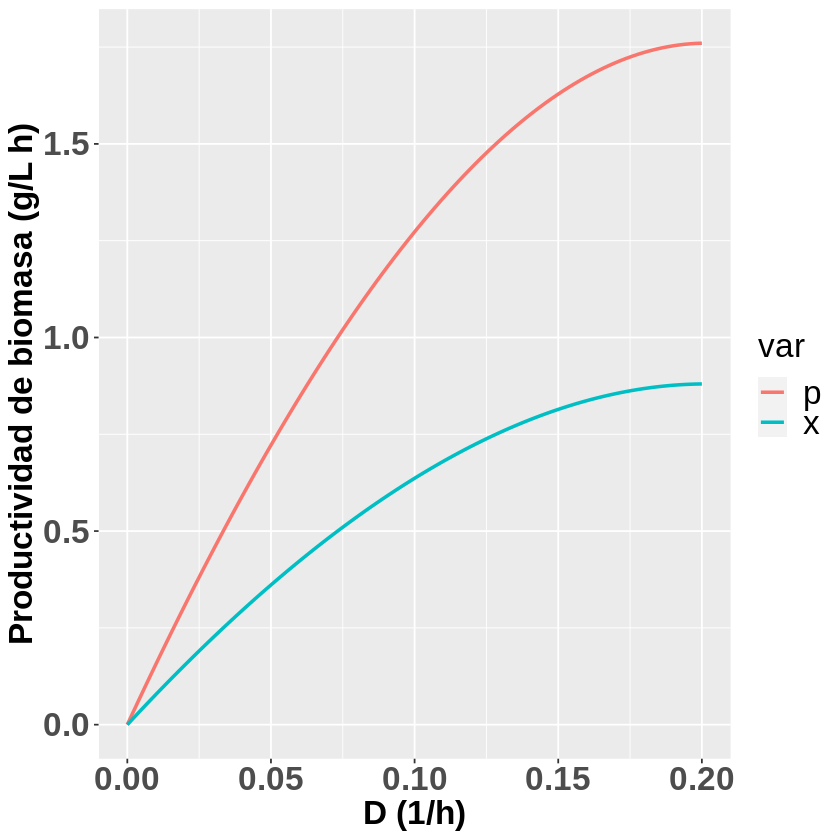

In [278]:
plot_productivity(out)

In [279]:
#@title función para obtener D_opt para un conjunto de parametros 
D_opt <- function(p) {
    with(as.list(p), {

        D_opt = mu_max*sf/(2*ks)

        return(D_opt)
    })
}

In [280]:
# derivada de la función de productividad 
deriv_productivity_func <- function(x, p) {
    with(as.list(p),{
        df = Yxs*(sf - ks*x*((2*mu_max - x)/(mu_max-x)^2))
        return(df)
    })
}

In [166]:
deriv_productivity_func(x = 0.43, p = p)

[1] -20.71732

In [168]:
# newton method 
gradient_method <- function(x0,alpha,eps,p) {
    grad = deriv_productivity_func(x0,p)
    while(abs(grad) > eps) {
        x = x0 + alpha*grad # sumar porque se busca subir por la colina
        x0 = x
        grad = deriv_productivity_func(x0,p)
    }
    return(list(sol = x, grad = grad))
}

In [281]:
x0 <- 0.05
alpha <- 0.01
eps <- 0.01
sol <- gradient_method(x0, alpha, eps, p)
productivity_opt <- productivity_func(sol$sol, p)

In [282]:
print(sol)
print(productivity_opt)

$sol
[1] 0.2013876

$grad
[1] 0.007918772

$productivity_x
[1] 0.880061

$productivity_p
[1] 1.760122



In [302]:
#@title función para graficar productividad con tasa de alimentación óptima
plot_productivity_Dopt <- function(out, sol, productivity) {
    # mostrar resultados 
    optima = data.frame(D = rep(sol$sol,2),
    productivity = c(productivity$productivity_x,productivity$productivity_p))

    ggplot(out, aes(x = D, y = productivity, color = var)) +
    geom_line(lty = 1, lwd = 1) +
    geom_vline(xintercept = sol$sol, color = "skyblue", lwd = 2, lty = 2) +
    geom_point(data = optima, col = "brown", cex = 5) +
    ylab("Productividad de biomasa (g/Lh)") +
    xlab("D (1/h)") +
    theme(
            plot.title = element_text(size=22),
            axis.text=element_text(size=20, face = "bold"),
            axis.title=element_text(size=20,face="bold"),
            legend.title = element_text(size=20), 
            legend.text = element_text(size=20))
}

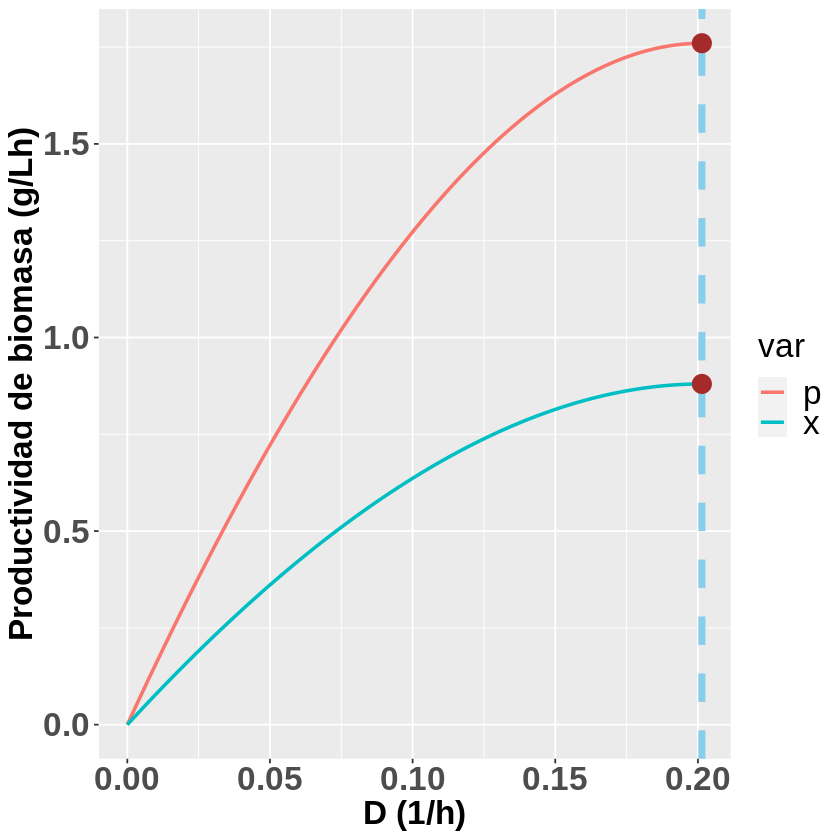

In [303]:
plot_productivity_Dopt(out,sol, productivity_opt)

### Valor superior para $D$

In [11]:
# función para calcular D*
D_bif <- function(p) {
  with(as.list(p), {

    D = mu_max*sf/(ks + sf)

    return(D)
  })
}

# Optimización con parámetros de *Isstchenkia terrícola*

Debemos proponer un valor para el parámetros $s_f$. Establezcamos $s_f = 50\ g/L$

In [241]:
# parámetros óptimos de Isstchenkia terrícola
p_it <- c(mu_max = 1.4536067, ks = 284.3997206, Yxs = 0.1092001, Ypx = 7.0414839, sf = 80)

In [242]:
# valor superior para D
D_bif(p_it)

[1] 0.3191236

In [243]:
# obtener productividad
productivity_it <- productivity_func(x,p_it)

# generar los datos para la gráfica
out_it <- get_data_productivity(productivity_it)
head(out_it)

,D,productivity,var
,<dbl>,<dbl>,<fct>
1,0.000000000,0.00000000,x
2,0.002020202,0.01756118,x
3,0.004040404,0.03494725,x
4,0.006060606,0.05215746,x
5,0.008080808,0.06919107,x
6,0.010101010,0.08604736,x


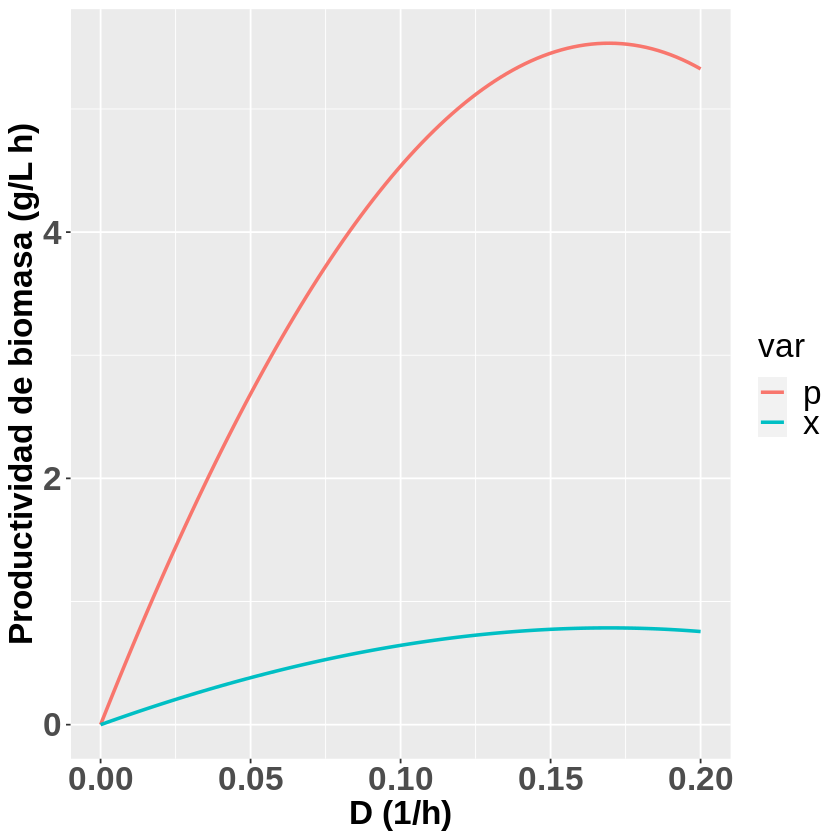

In [244]:
plot_productivity(out_it)

### Realizar optimización 

In [293]:
sol_it <- gradient_method(x0, alpha, eps, p_it)
productivity_opt_it <- productivity_func(sol_it$sol, p_it)

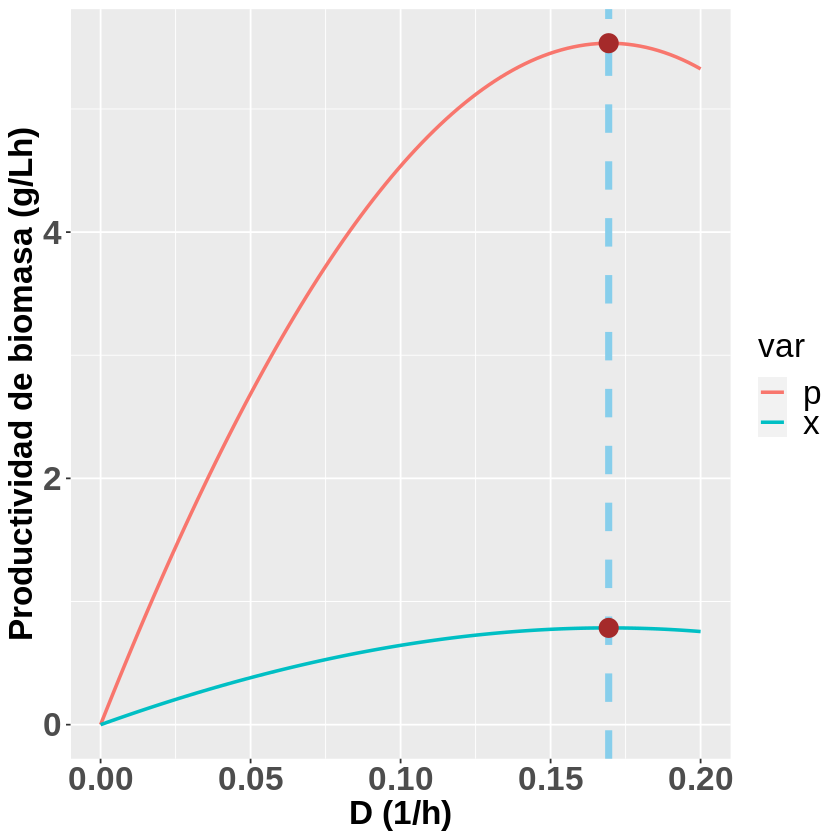

In [304]:
plot_productivity_Dopt(out_it,sol_it, productivity_opt_it)

# Optimización con parámetros de *Kluyveromyces marxianus*

In [245]:
# parámetros óptimo para Kluyveromyces marxianus
p_km <- c(mu_max = 1.0110607, ks = 353.3425303, Yxs = 0.1301708, Ypx = 4.9448320, sf = 80)      

In [246]:
D_bif(p_km)

[1] 0.1866534

In [247]:
# obtener productividad
productivity_km <- productivity_func(x,p_km)

# generar los datos para la gráfica
out_km <- get_data_productivity(productivity_km)
head(out_km)

,D,productivity,var
,<dbl>,<dbl>,<fct>
1,0.000000000,0.00000000,x
2,0.002020202,0.02085167,x
3,0.004040404,0.04132978,x
4,0.006060606,0.06143209,x
5,0.008080808,0.08115630,x
6,0.010101010,0.10050015,x


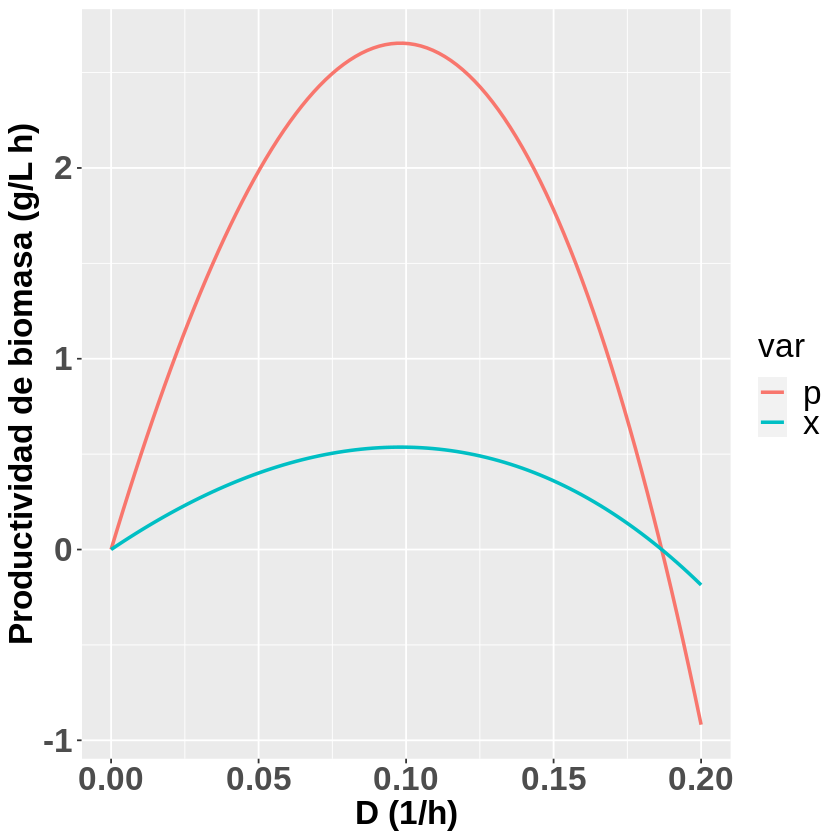

In [248]:
plot_productivity(out_km)

### Realizar optimización 

In [306]:
sol_km <- gradient_method(x0, alpha, eps, p_km)
productivity_opt_km <- productivity_func(sol_km$sol, p_km)

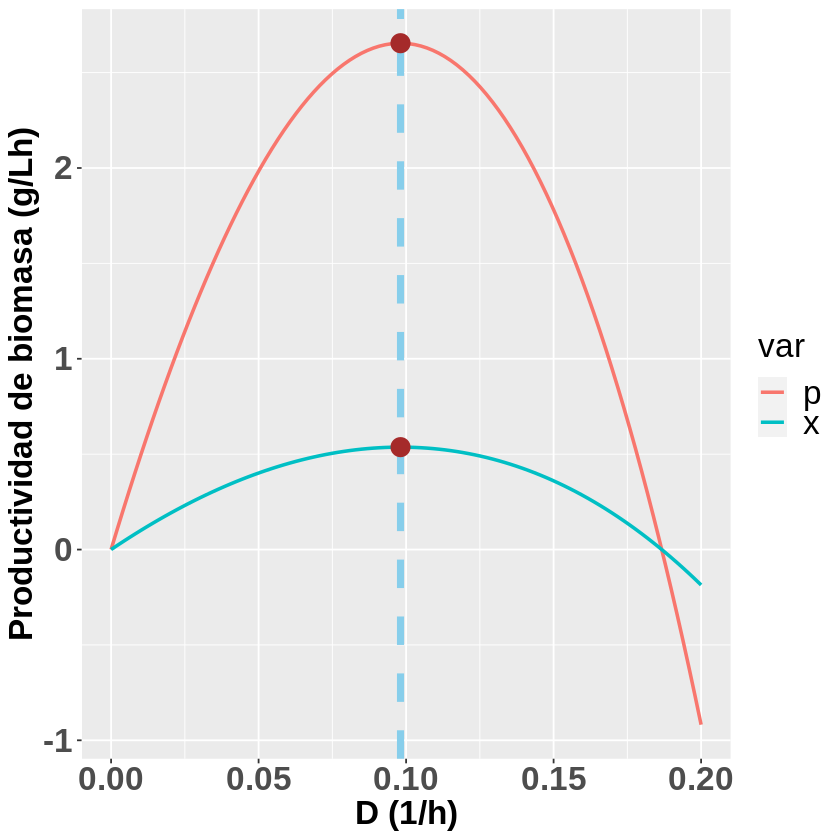

In [307]:
plot_productivity_Dopt(out_km, sol_km,productivity_opt_km)

# Optimización con parámetros de *Pichia kluyveri*

In [249]:
# parámetros óptimos de Pichia kluyveri
p_pk <- c(mu_max = 0.6588448, ks = 366.8216124, Yxs = 0.1032014, Ypx = 3.8650679, sf = 80)  

In [250]:
D_bif(p_pk)

[1] 0.1179611

In [251]:
# obtener productividad
productivity_pk <- productivity_func(x,p_pk)

# generar los datos para la gráfica
out_pk <- get_data_productivity(productivity_pk)
head(out_pk)

,D,productivity,var
,<dbl>,<dbl>,<fct>
1,0.000000000,0.00000000,x
2,0.002020202,0.01644379,x
3,0.004040404,0.03241423,x
4,0.006060606,0.04790693,x
5,0.008080808,0.06291743,x
6,0.010101010,0.07744123,x


### Realizar optimización 

In [308]:
sol_pk <- gradient_method(x0,alpha,eps,p_pk)
productivity_opt_pk <- productivity_func(sol_pk$sol, p_pk)

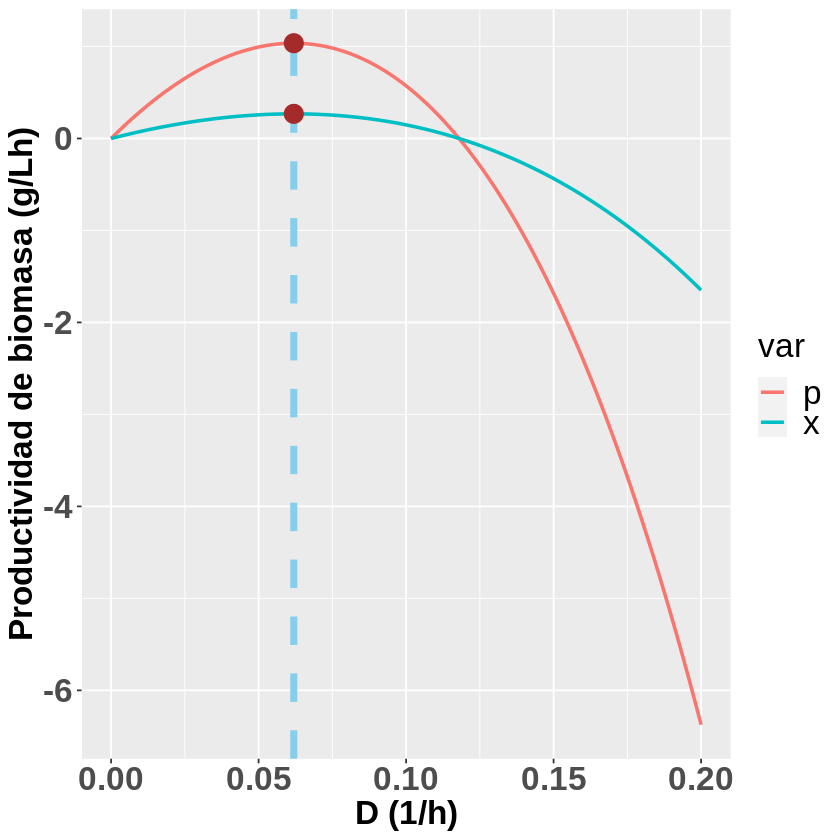

In [309]:
plot_productivity_Dopt(out_pk, sol_pk,productivity_opt_pk)

# Optimización con parámetros de *Zygosaccharomyces bailii*

In [254]:
# parámetros óptimos de Zygosaccharomyces bailii
p_zb <- c(mu_max = 1.1682471, ks = 300.1541664, Yxs = 0.1171282, Ypx = 4.9301197, sf = 80)  

In [255]:
D_bif(p_zb)

[1] 0.245847

In [256]:
# obtener productividad
productivity_zb <- productivity_func(x,p_zb)

# generar los datos para la gráfica
out_zb <- get_data_productivity(productivity_zb)
head(out_zb)

,D,productivity,var
,<dbl>,<dbl>,<fct>
1,0.000000000,0.00000000,x
2,0.002020202,0.01880678,x
3,0.004040404,0.03736664,x
4,0.006060606,0.05567831,x
5,0.008080808,0.07374047,x
6,0.010101010,0.09155183,x


### Realizar optimización 

In [310]:
sol_zb <- gradient_method(x0, alpha, eps, p_zb)
productivity_opt_zb <- productivity_func(sol_zb$sol, p_zb)

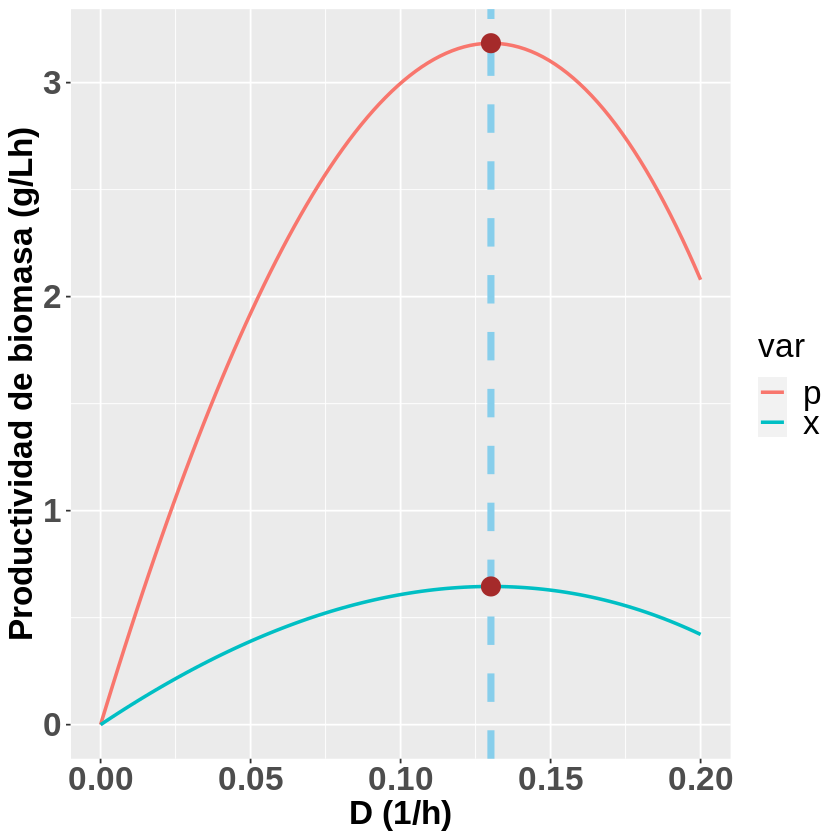

In [311]:
plot_productivity_Dopt(out_zb, sol_zb, productivity_opt_zb)

# Optimización con parámetros de *Zigosaccharomyces rouxi*

In [259]:
# parámetros óptimos de Zygosaccharomyces bailii
p_zr <- c(mu_max = 0.5003527, ks = 250.9052285, Yxs = 0.1950366, Ypx = 3.1550382, sf = 80) 

In [260]:
D_bif(p_zr)

[1] 0.1209658

In [261]:
# obtener productividad
productivity_zr <- productivity_func(x, p_zr)

# generar datos para la gráfica
out_zr <- get_data_productivity(productivity = productivity_zr)
head(out_zr)

,D,productivity,var
,<dbl>,<dbl>,<fct>
1,0.000000000,0.00000000,x
2,0.002020202,0.03112030,x
3,0.004040404,0.06143252,x
4,0.006060606,0.09092678,x
5,0.008080808,0.11959299,x
6,0.010101010,0.14742091,x


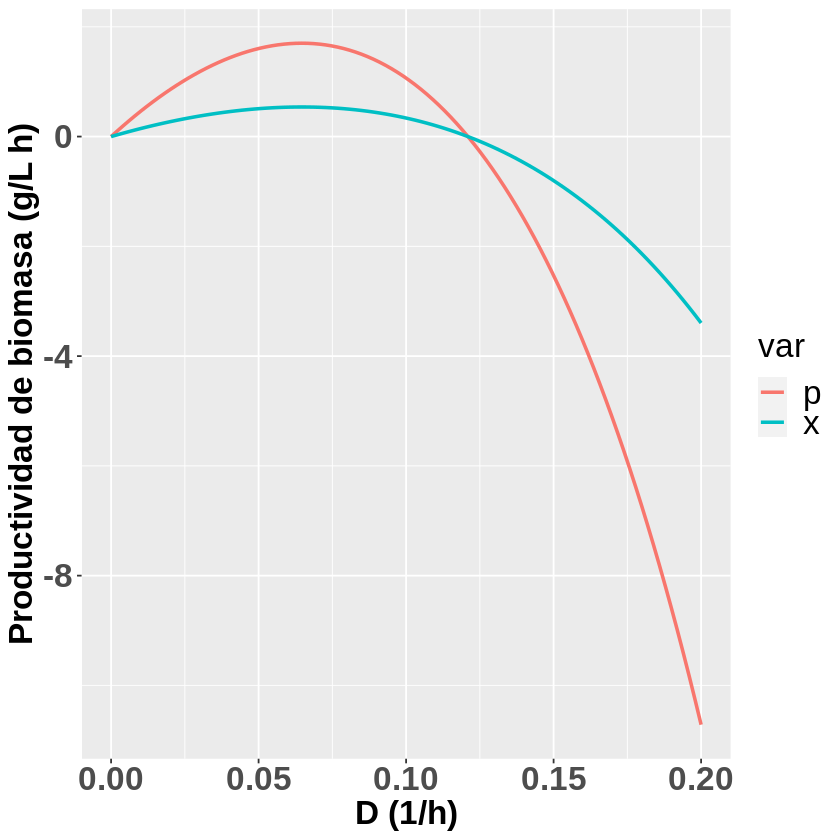

In [262]:
plot_productivity(out_zr)

### Realizar optimización 

In [312]:
sol_zr <- gradient_method(x0, alpha, 0.1, p_zr)
productivity_opt_zr <- productivity_func(sol_zr$sol, p_zr)

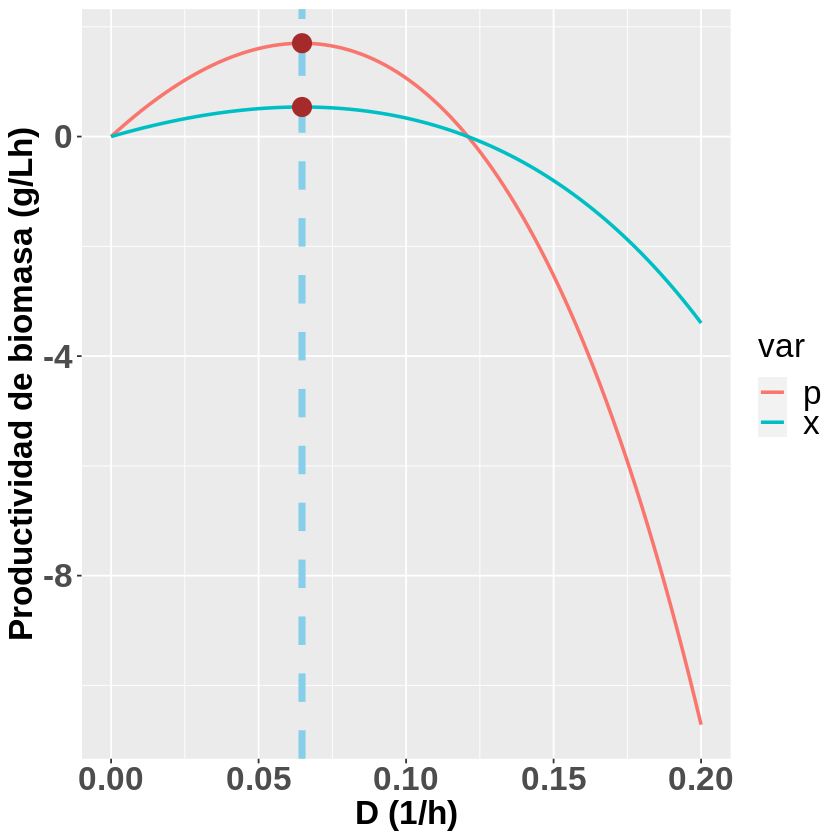

In [313]:
plot_productivity_Dopt(out_zr, sol_zr,productivity_opt_zr)

# Resultados 

Tabla 1. Valores de $D_{opt}$, $\dot{m}_x$ y $\dot{m}_p$ obtenido para las diferentes levaduras 

| levadura | $D$ | $\dot{m}_x$ | $\dot{m}_p$ |
|:---:|:---:|:---:|:---:|
| Isstchenkia terrícola | $0.113\ h^{-1}$ | $0.321\ g/h$ | $2.261\ g/h$ |
| Kluyveromyces marxianus | $0.0762\ h^{-1}$ | $0.309\ g/h$ |$1.523\ g/h$ |
| Pichia kluyveri | $0.0407\ h^{-1}$ | $0.1085\ g/h$ |$0.4186\ g/h$ |
| Zygosaccharomyces bailii | $0.0866\ h^{-1}$ | $0.2634\ g/h$ |$1.2986\ g/h$ |
| Zigosaccharomyces rouxi |$0.04345\ h^{-1}$ | $0.2215\ g/h$ |$0.6988\ g/h$ |

In [322]:
#@title D óptimos 
cat("Isstchenkia terrícola \n")
cat("D_opt:", sol_it$sol, "(1/h) \n\n")
cat("Kluyveromyces marxianus \n")
cat("D_opt:", sol_km$sol, "(1/h) \n\n")
cat("Pichia kluyveri \n")
cat("D_opt:", sol_pk$sol, "(1/h) \n\n")
cat("Zygosaccharomyces bailii \n")
cat("D_opt:", sol_zb$sol, "(1/h) \n\n")
cat("{Zigosaccharomyces rouxi \n")
cat("D_opt:", sol_zr$sol, "(1/h)")

Isstchenkia terrícola 
D_opt: 0.169363 (1/h) 

Kluyveromyces marxianus 
D_opt: 0.09810681 (1/h) 

Pichia kluyveri 
D_opt: 0.0619346 (1/h) 

Zygosaccharomyces bailii 
D_opt: 0.1301124 (1/h) 

{Zigosaccharomyces rouxi 
D_opt: 0.06472541 (1/h)

In [323]:
#@title mx máximo 
cat("Isstchenkia terrícola \n")
cat("mx_max: ", productivity_opt_it$productivity_x, "g/Lh \n\n")
cat("Kluyveromyces marxianus \n")
cat("mx_max: ", productivity_opt_km$productivity_x, "g/Lh \n\n")
cat("Pichia kluyveri \n")
cat("mx_max: ", productivity_opt_pk$productivity_x, "g/Lh \n\n")
cat("Zygosaccharomyces bailii \n")
cat("mx_max: ", productivity_opt_zb$productivity_x, "g/Lh \n\n")
cat("Zigosaccharomyces rouxi \n")
cat("mx_max: ", productivity_opt_zr$productivity_x, "g/Lh")

Isstchenkia terrícola 
mx_max:  0.7859042 g/Lh 

Kluyveromyces marxianus 
mx_max:  0.5367438 g/Lh 

Pichia kluyveri 
mx_max:  0.2680636 g/Lh 

Zygosaccharomyces bailii 
mx_max:  0.6458765 g/Lh 

Zigosaccharomyces rouxi 
mx_max:  0.5392968 g/Lh

In [324]:
#@title mp máximo 
cat("Isstchenkia terrícola \n")
cat("mp_max: ", productivity_opt_it$productivity_p, "g/Lh \n\n")
cat("Kluyveromyces marxianus \n")
cat("mp_max: ", productivity_opt_km$productivity_p, "g/Lh \n\n")
cat("Pichia kluyveri \n")
cat("mp_max: ", productivity_opt_pk$productivity_p, "g/Lh \n\n")
cat("Zygosaccharomyces bailii \n")
cat("mp_max: ", productivity_opt_zb$productivity_p, "g/Lh \n\n")
cat("Zigosaccharomyces rouxi \n")
cat("mp_max: ", productivity_opt_zr$productivity_p, "g/Lh")

Isstchenkia terrícola 
mp_max:  5.533932 g/Lh 

Kluyveromyces marxianus 
mp_max:  2.654108 g/Lh 

Pichia kluyveri 
mp_max:  1.036084 g/Lh 

Zygosaccharomyces bailii 
mp_max:  3.184248 g/Lh 

Zigosaccharomyces rouxi 
mp_max:  1.701502 g/Lh

### Gráfica de barras con tasas de dilución óptimas 

In [328]:
data_Dopt <- data.frame(lev = c("IT","KM","PK","ZB","ZR"),
                    Dopt = c(sol_it$sol,sol_km$sol,sol_pk$sol,sol_zb$sol,sol_zr$sol))

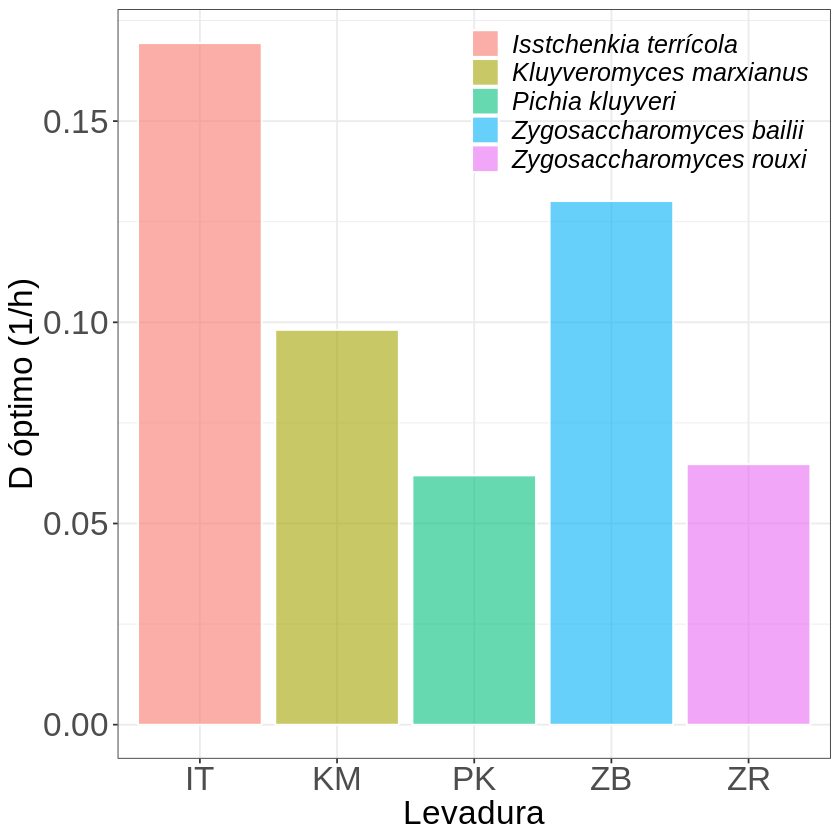

In [329]:
ggplot(data=data_Dopt, aes(x=lev, y=Dopt, fill = lev)) +
  geom_bar(stat="identity", color="white", alpha = 0.6) +
  xlab("Levadura") +
  ylab("D óptimo (1/h)") +
  scale_fill_discrete(name = "", labels = c("Isstchenkia terrícola", 
  "Kluyveromyces marxianus", "Pichia kluyveri","Zygosaccharomyces bailii",
  "Zygosaccharomyces rouxi")) +
  theme_bw() +
  theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic",   ),
            legend.position = c(0.73, 0.90), 
            legend.background = element_rect(fill=NA))
            

In [332]:
install.packages("tidyverse")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [333]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [361]:
get_data_productivity_var <- function(out,variable) {
    out <- filter(out, var == variable) %>% select(productivity) %>% unlist()
    return(out)
}

In [367]:
tail(get_data_productivity_var(out_it,"x"))

productivity95  productivity96  productivity97  productivity98  productivity99 
      0.7727201       0.7699627       0.7669387       0.7636467       0.7600854 
productivity100 
      0.7562535

In [366]:
variable <- "x"
productivity_x <- data.frame(D = rep(out_it$D, 5), lev = rep(c("IT","KM","PK","ZB","ZR"), each = length(out_it$D)), 
                    productivity = c(get_data_productivity_var(out_it,variable),get_data_productivity_var(out_km,variable),
                    get_data_productivity_var(out_pk,variable),get_data_productivity_var(out_zb,variable),
                    get_data_productivity_var(out_zr,variable)) )
head(productivity_x)

[1] 0.000000000 0.002020202 0.004040404 0.006060606 0.008080808 0.010101010
  [7] 0.012121212 0.014141414 0.016161616 0.018181818 0.020202020 0.022222222
 [13] 0.024242424 0.026262626 0.028282828 0.030303030 0.032323232 0.034343434
 [19] 0.036363636 0.038383838 0.040404040 0.042424242 0.044444444 0.046464646
 [25] 0.048484848 0.050505051 0.052525253 0.054545455 0.056565657 0.058585859
 [31] 0.060606061 0.062626263 0.064646465 0.066666667 0.068686869 0.070707071
 [37] 0.072727273 0.074747475 0.076767677 0.078787879 0.080808081 0.082828283
 [43] 0.084848485 0.086868687 0.088888889 0.090909091 0.092929293 0.094949495
 [49] 0.096969697 0.098989899 0.101010101 0.103030303 0.105050505 0.107070707
 [55] 0.109090909 0.111111111 0.113131313 0.115151515 0.117171717 0.119191919
 [61] 0.121212121 0.123232323 0.125252525 0.127272727 0.129292929 0.131313131
 [67] 0.133333333 0.135353535 0.137373737 0.139393939 0.141414141 0.143434343
 [73] 0.145454545 0.147474747 0.149494949 0.151515152 0.153535354 0.155555556
 [79] 0.157575758 0.159595960 0.161616162 0.163636364 0.165656566 0.167676768
 [85] 0.169696970 0.171717172 0.173737374 0.175757576 0.177777778 0.179797980
 [91] 0.181818182 0.183838384 0.185858586 0.187878788 0.189898990 0.191919192
 [97] 0.193939394 0.195959596 0.197979798 0.200000000 0.000000000 0.002020202
[103] 0.004040404 0.006060606 0.008080808 0.010101010 0.012121212 0.014141414
[109] 0.016161616 0.018181818 0.020202020 0.022222222 0.024242424 0.026262626
[115] 0.028282828 0.030303030 0.032323232 0.034343434 0.036363636 0.038383838
[121] 0.040404040 0.042424242 0.044444444 0.046464646 0.048484848 0.050505051
[127] 0.052525253 0.054545455 0.056565657 0.058585859 0.060606061 0.062626263
[133] 0.064646465 0.066666667 0.068686869 0.070707071 0.072727273 0.074747475
[139] 0.076767677 0.078787879 0.080808081 0.082828283 0.084848485 0.086868687
[145] 0.088888889 0.090909091 0.092929293 0.094949495 0.096969697 0.098989899
[151] 0.101010101 0.103030303 0.105050505 0.107070707 0.109090909 0.111111111
[157] 0.113131313 0.115151515 0.117171717 0.119191919 0.121212121 0.123232323
[163] 0.125252525 0.127272727 0.129292929 0.131313131 0.133333333 0.135353535
[169] 0.137373737 0.139393939 0.141414141 0.143434343 0.145454545 0.147474747
[175] 0.149494949 0.151515152 0.153535354 0.155555556 0.157575758 0.159595960
[181] 0.161616162 0.163636364 0.165656566 0.167676768 0.169696970 0.171717172
[187] 0.173737374 0.175757576 0.177777778 0.179797980 0.181818182 0.183838384
[193] 0.185858586 0.187878788 0.189898990 0.191919192 0.193939394 0.195959596
[199] 0.197979798 0.200000000

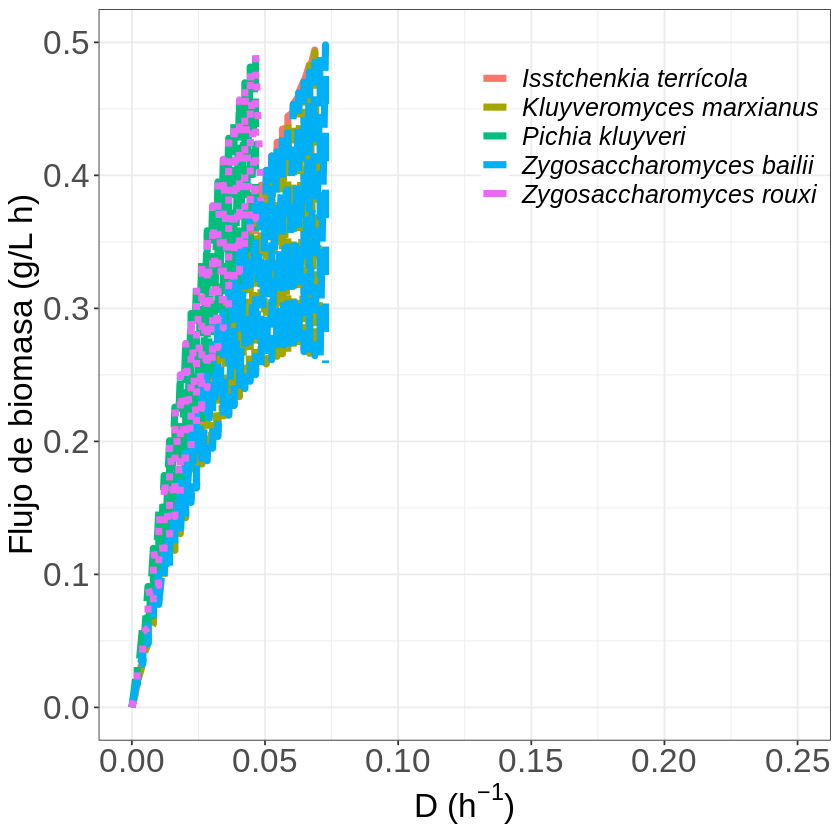

In [365]:
# mostrar resultados 
ggplot(data = productivity_x, aes(x = D, y = productivity, group = lev)) +
  geom_line(aes(linetype = lev, color = lev), lwd = 2) +
  geom_vline(xintercept = sol_it$minimum, color = "red", size = 1, lty = 2) +
  geom_vline(xintercept = sol_km$minimum, color = "red", size = 1, lty = 2) +
  geom_vline(xintercept = sol_pk$minimum, color = "red", size = 1, lty = 2) +
  geom_vline(xintercept = sol_zb$minimum, color = "red", size = 1, lty = 2) +
  geom_vline(xintercept = sol_zr$minimum, color = "red", size = 1, lty = 2) +
  #geom_point(x = sol_it$minimum, y =  - sol_it$objective, color = "red", size = 5) +
  ylab("Flujo de biomasa (g/L h)") +
  xlab(expression("D ("*h^-1*")")) +
  xlim(c(0,0.25))+
  ylim(c(0,0.5)) +
  scale_linetype_discrete(name = "", c("Isstchenkia terrícola", 
  "Kluyveromyces marxianus", "Pichia kluyveri","Zygosaccharomyces bailii",
  "Zygosaccharomyces rouxi")) +
  scale_color_discrete(name = "", labels = c("Isstchenkia terrícola", 
  "Kluyveromyces marxianus", "Pichia kluyveri","Zygosaccharomyces bailii",
  "Zygosaccharomyces rouxi")) +
  theme_bw() +
  theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic"),
            legend.position = c(0.75,0.85), 
            legend.background = element_rect(fill=NA))

In [50]:
options(warn =  -1)

### Gráfica de barras para la producción de biomasa 

In [51]:
data_mx <- data.frame(lev = c("IT","KM","PK","ZB","ZR"),
                    mx = c(-sol_it$objective,-sol_km$objective,-sol_pk$objective,-sol_zb$objective,-sol_zr$objective))

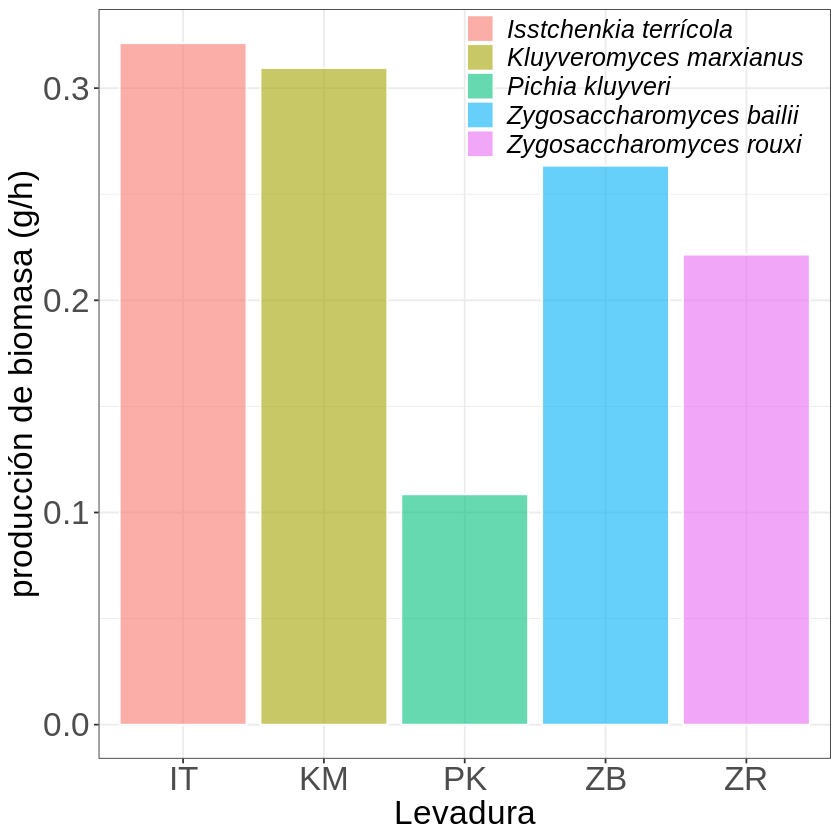

In [52]:
ggplot(data=data_mx, aes(x=lev, y=mx, fill = lev)) +
  geom_bar(stat="identity", color="white", alpha = 0.6) +
  xlab("Levadura") +
  ylab("producción de biomasa (g/h)") +
  scale_fill_discrete(name = "", labels = c("Isstchenkia terrícola", 
  "Kluyveromyces marxianus", "Pichia kluyveri","Zygosaccharomyces bailii",
  "Zygosaccharomyces rouxi")) +
  theme_bw() +
  theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic",   ),
            legend.position = c(0.73, 0.92), 
            legend.background = element_rect(fill=NA))
            

### Gráfica de barras para la producción de etanol

In [53]:
data_mp <- data.frame(lev = c("IT","KM","PK","ZB","ZR"),
                    mx = c(Gain2(7.041,- sol_it$objective),Gain2(4.944,- sol_km$objective),
                    Gain2(3.865,- sol_pk$objective),Gain2(4.930,- sol_zb$objective),
                    Gain2(3.155,- sol_zr$objective)))

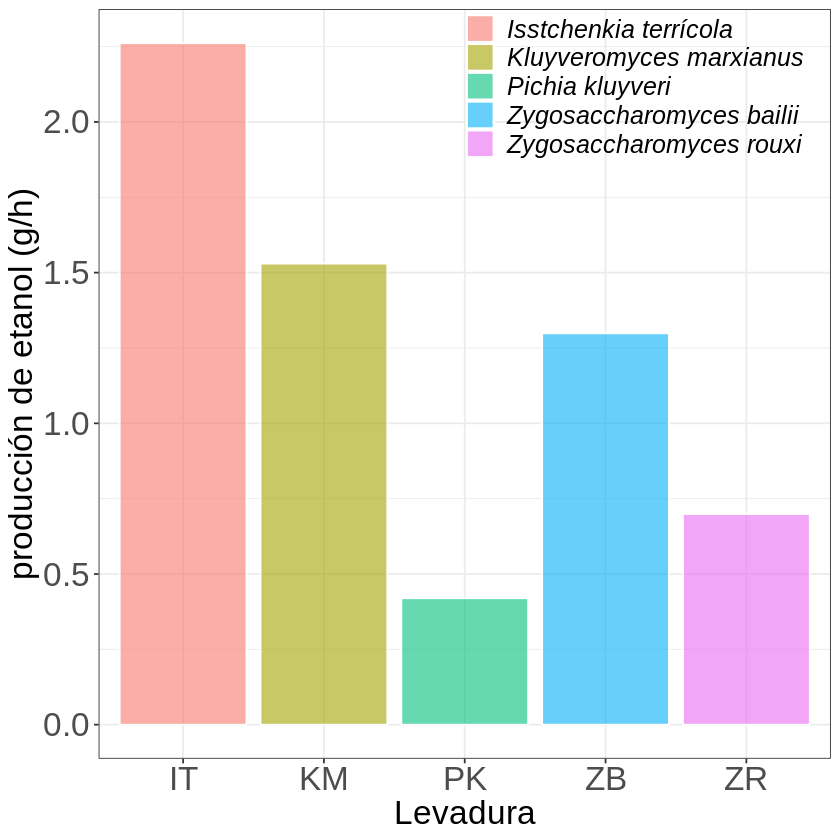

In [54]:
ggplot(data=data_mp, aes(x=lev, y=mx, fill = lev)) +
  geom_bar(stat="identity", color="white", alpha = 0.6) +
  xlab("Levadura") +
  ylab("producción de etanol (g/h)") +
  scale_fill_discrete(name = "", labels = c("Isstchenkia terrícola", 
  "Kluyveromyces marxianus", "Pichia kluyveri","Zygosaccharomyces bailii",
  "Zygosaccharomyces rouxi")) +
  theme_bw() +
  theme( 
            plot.title = element_text(size=25),
            axis.text = element_text(size=20),
            axis.title = element_text(size=20),
            legend.title = element_text(size=15), 
            legend.text = element_text(size=15, face = "italic",   ),
            legend.position = c(0.73, 0.92), 
            legend.background = element_rect(fill=NA))
            